In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import librosa
import librosa.display
from IPython.display import Audio
import os
os.environ['WANDB_DISABLED'] = 'true'


In [2]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

dataset_files = os.listdir(path)

print("Files in the dataset directory:")
for file_name in dataset_files:
    print(file_name)

Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Files in the dataset directory:
TESS Toronto emotional speech set data
tess toronto emotional speech set data


In [3]:
data_subfolder = 'TESS Toronto emotional speech set data'
data_path = os.path.join(path, data_subfolder)

**Reasoning**:
The previous step successfully explored the directory structure. Now, I need to collect all audio file paths and extract their corresponding emotional labels to prepare the data for further analysis. A pandas DataFrame is an appropriate structure to store this information.



In [4]:
file_paths = []
emotions = []

for root, dirs, files in os.walk(data_path):
    for file_name in files:
        if file_name.endswith('.wav'):
            file_path = os.path.join(root, file_name)
            file_paths.append(file_path)

            # Extract emotion from the folder name (e.g., 'YAF_fear' -> 'fear')
            emotion = os.path.basename(root).split('_')[-1].lower()
            # Handle 'pleasant_surprise' case if it exists as 'Pleasant_surprise'
            if emotion == 'surprise':
                if 'pleasant_surprise' in os.path.basename(root).lower():
                    emotion = 'pleasant_surprise'
            emotions.append(emotion)

# Create a DataFrame
df = pd.DataFrame({
    'File_Path': file_paths,
    'Emotion': emotions
})

print(f"Total audio files found: {len(df)}")
print("First 5 rows of the DataFrame:")
print(df.head())
print("\nEmotion distribution:")
print(df['Emotion'].value_counts())


Total audio files found: 2800
First 5 rows of the DataFrame:
                                           File_Path Emotion
0  /kaggle/input/toronto-emotional-speech-set-tes...    fear
1  /kaggle/input/toronto-emotional-speech-set-tes...    fear
2  /kaggle/input/toronto-emotional-speech-set-tes...    fear
3  /kaggle/input/toronto-emotional-speech-set-tes...    fear
4  /kaggle/input/toronto-emotional-speech-set-tes...    fear

Emotion distribution:
Emotion
fear                 400
angry                400
disgust              400
neutral              400
sad                  400
happy                400
pleasant_surprise    200
surprised            200
Name: count, dtype: int64


<Axes: xlabel='Emotion', ylabel='count'>

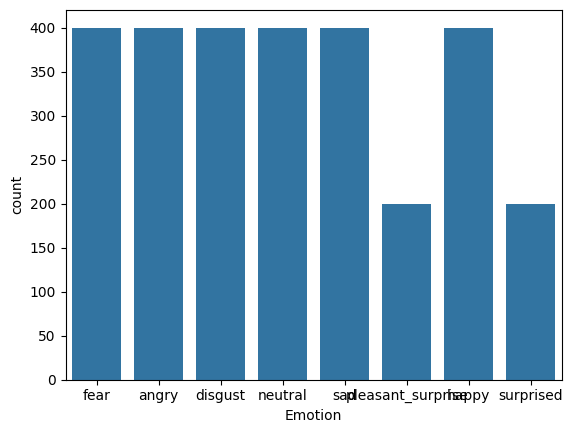

In [5]:
sns.countplot(data=df, x='Emotion')

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

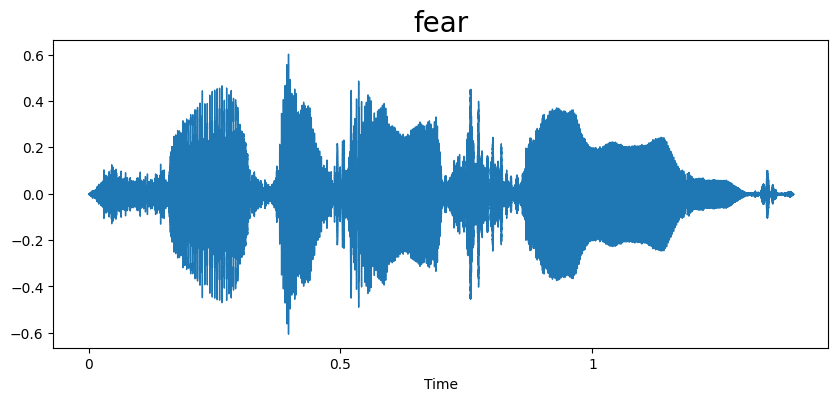

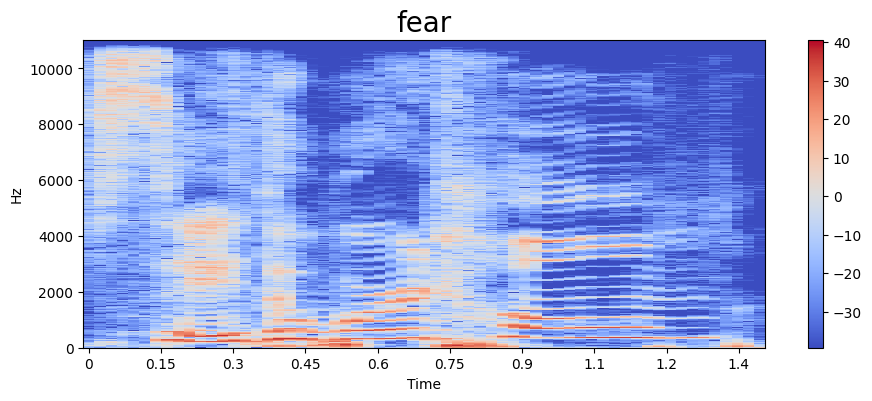

In [7]:
emotion = 'fear'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

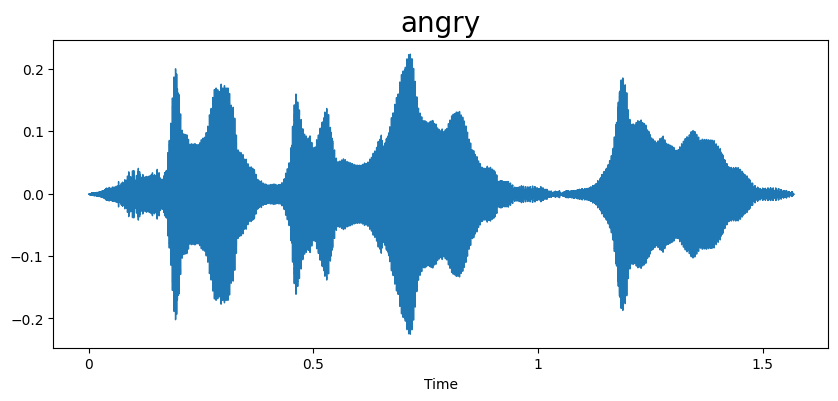

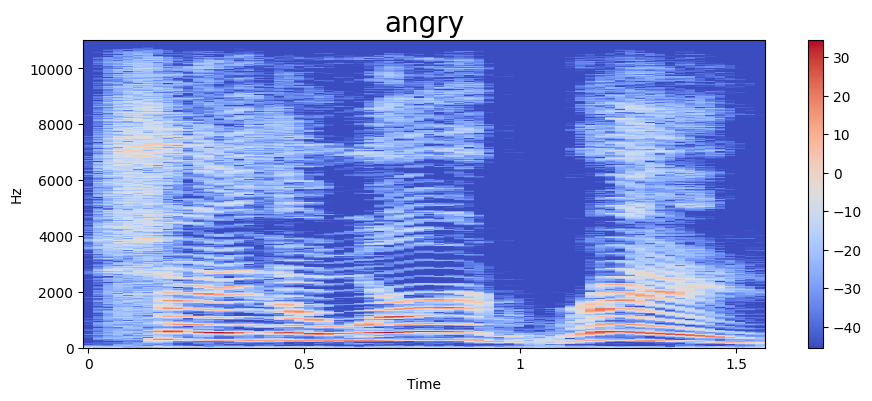

In [8]:
emotion = 'angry'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

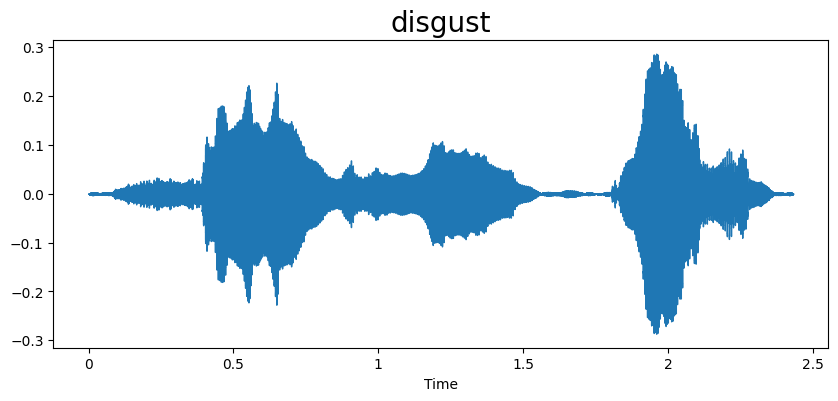

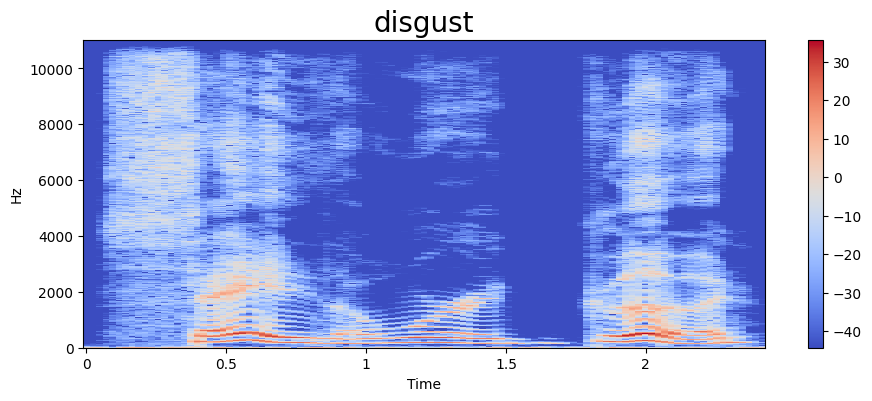

In [9]:
emotion = 'disgust'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

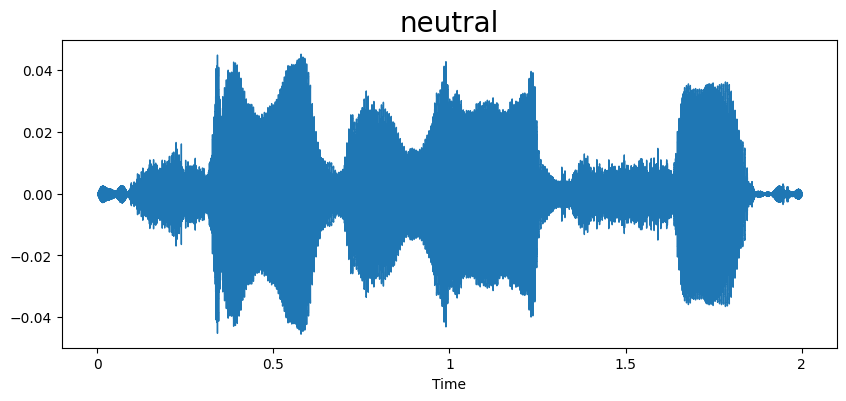

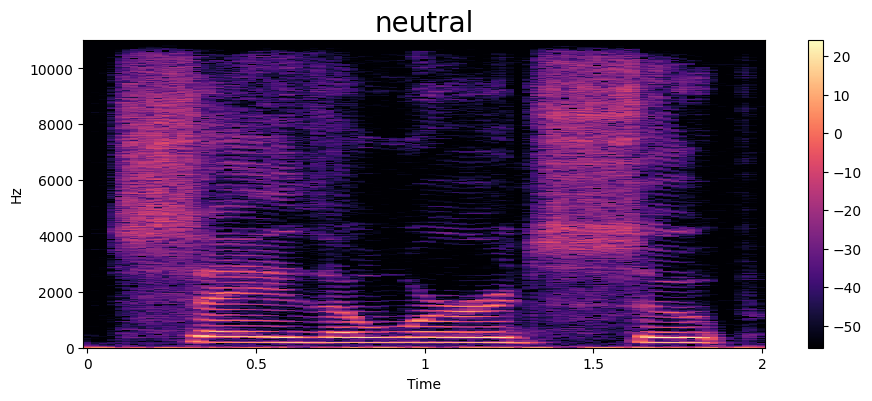

In [10]:
emotion = 'neutral'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

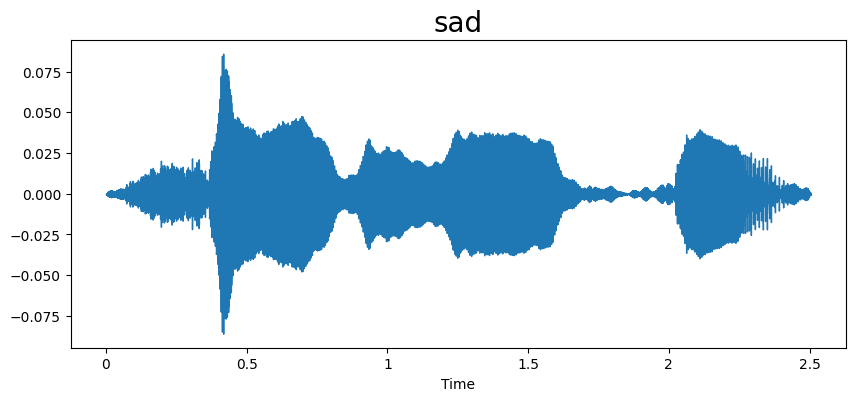

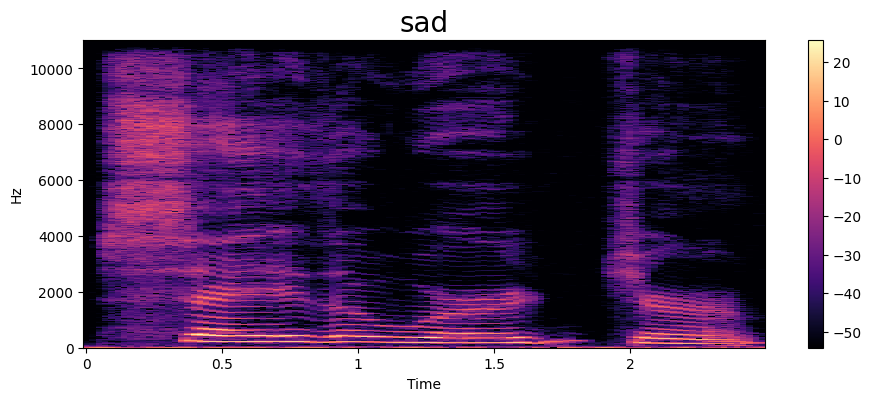

In [11]:
emotion = 'sad'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

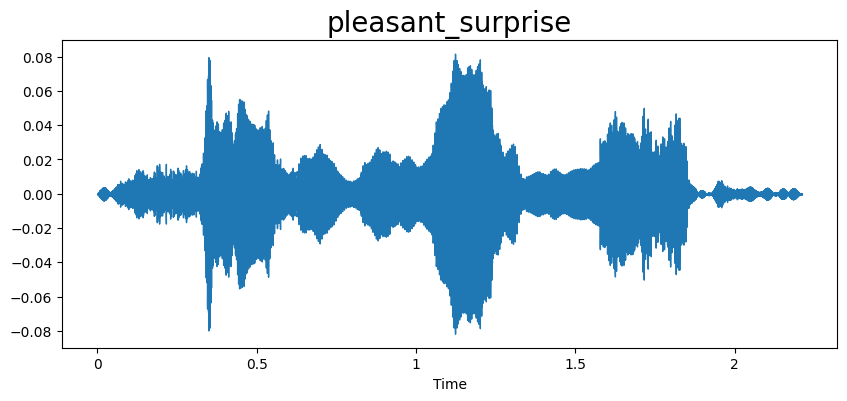

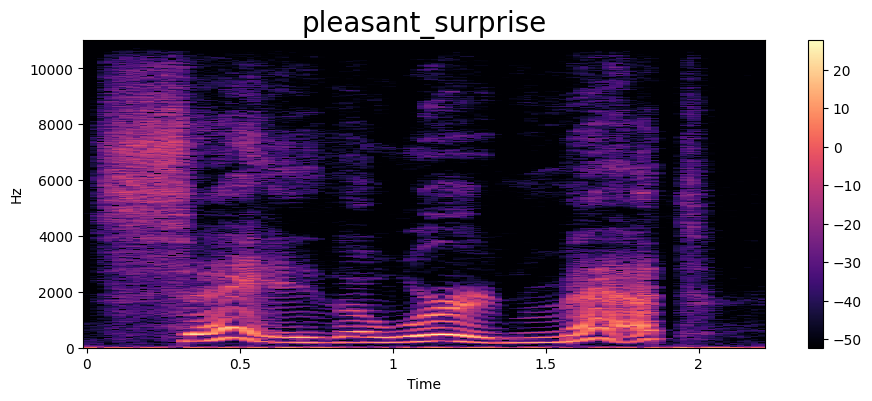

In [12]:
emotion = 'pleasant_surprise'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

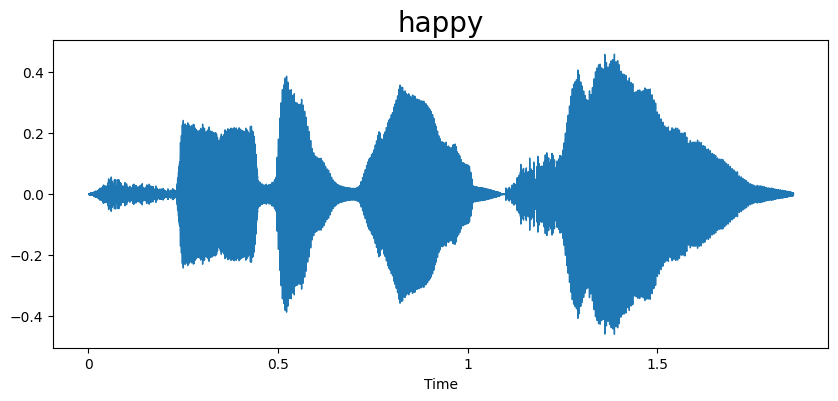

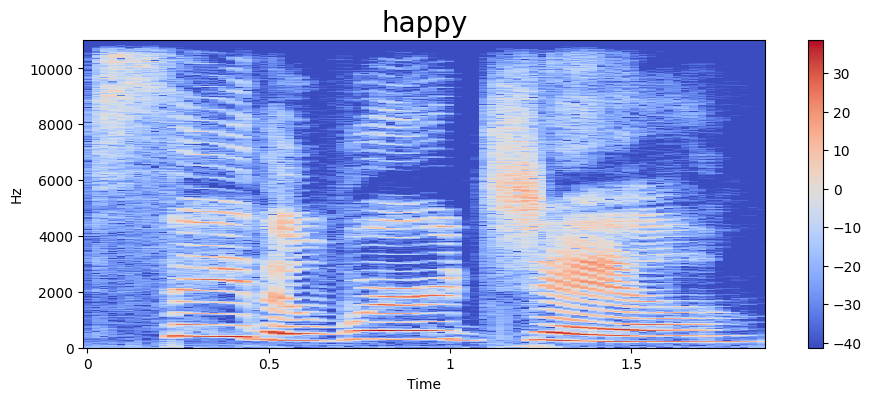

In [13]:
emotion = 'happy'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

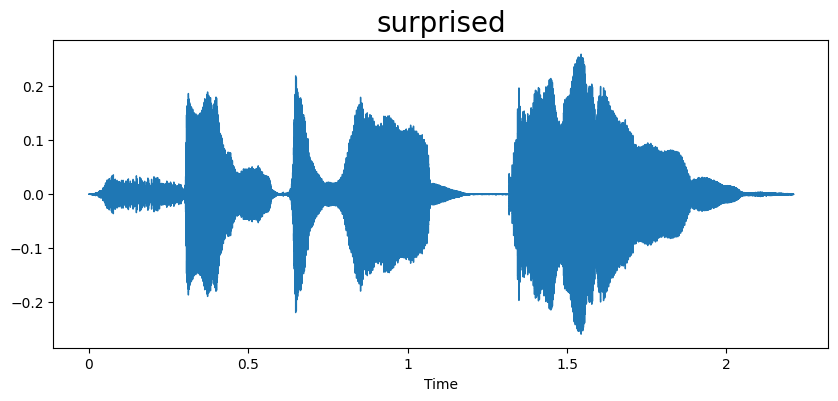

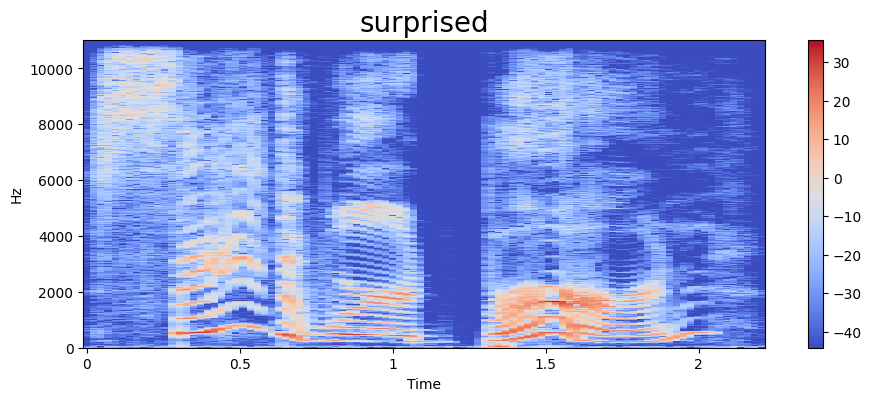

In [14]:
emotion = 'surprised'
path = np.array(df['File_Path'][df['Emotion'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [15]:
label_map = {label: idx for idx, label in enumerate(df['Emotion'].unique())}
df['Emotion'] = df['Emotion'].map(label_map)
df.head()

,File_Path,Emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,0
1,/kaggle/input/toronto-emotional-speech-set-tes...,0
2,/kaggle/input/toronto-emotional-speech-set-tes...,0
3,/kaggle/input/toronto-emotional-speech-set-tes...,0
4,/kaggle/input/toronto-emotional-speech-set-tes...,0


In [16]:
import torch
from torch.utils.data import Dataset

class speechEmotionDataset(Dataset):
  def __init__(self, df, processor, max_length=16000):
    self.df = df
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    file_path = self.df.iloc[idx, 0]
    emotion = self.df.iloc[idx, 1]

    # Load the audio file
    speech, sr = librosa.load(file_path, sr=16000)
    # librosa.load returns a numpy array, no need for .numpy()
    speech = speech.squeeze()

    if len(speech) > self.max_length:
      speech = speech[:self.max_length]
    else:
      pad_length = self.max_length - len(speech)
      speech = np.pad(speech, (0, pad_length), mode='constant')

    inputs = self.processor(speech, sampling_rate=sr, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
    inputs['labels'] = torch.tensor([emotion]).long()

    # Correct variable name from 'input' to 'inputs'
    input_values = inputs.input_values.squeeze(0)
    input_length = torch.tensor([len(input_values)])

    return inputs

In [17]:
#Splitting the data for training and testing
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [18]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

#initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=len(label_map))

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
train_dataset = speechEmotionDataset(train_df, processor)
test_dataset = speechEmotionDataset(test_df, processor)

In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    eval_strategy="steps", # Corrected from evaluation_strategy
    num_train_epochs=1,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=100,
    learning_rate=1e-5,
    save_total_limit=2,
    push_to_hub=False,

    report_to='none', # Disable wandb logging
    remove_unused_columns=False, # Keep unused columns for label processing
    load_best_model_at_end=True,
)

In [21]:
import torch

def collate_fn(batch):
    # Extract input_values (processed audio features) and labels from the batch
    input_values = [item['input_values'].squeeze(0) for item in batch]
    labels = [item['labels'].squeeze(0) for item in batch]

    # Pad the input_values to the maximum length in the batch
    # This assumes input_values are 1D tensors (audio samples)
    padded_input_values = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True, padding_value=0.0)

    # Stack labels into a single tensor
    labels = torch.stack(labels)

    return {
        'input_values': padded_input_values,
        'labels': labels
    }

In [22]:
from transformers import Trainer
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.000000,2.087800,0.055357


TrainOutput(global_step=140, training_loss=0.0, metrics={'train_runtime': 67.8772, 'train_samples_per_second': 33.001, 'train_steps_per_second': 2.063, 'total_flos': 2.033646870528e+16, 'train_loss': 0.0, 'epoch': 1.0})

In [23]:
results = trainer.evaluate()
print(results)

{'eval_loss': 2.0878000259399414, 'eval_accuracy': 0.055357142857142855, 'eval_runtime': 3.5164, 'eval_samples_per_second': 159.252, 'eval_steps_per_second': 19.906, 'epoch': 1.0}


In [25]:
import os
import json
import shutil

# Define output
output_dir = "saved_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# COPY FROM CHECKPOINT (I see checkpoint-140 in your image)
# If your latest is different, change '140' to the highest number you see.
checkpoint_dir = "./results/checkpoint-140"

print(f"Packaging model from {checkpoint_dir}...")

# Copy model files
files_to_copy = ["model.safetensors", "config.json", "preprocessor_config.json", "pytorch_model.bin"]
for file in files_to_copy:
    src = f"{checkpoint_dir}/{file}"
    dst = f"{output_dir}/{file}"
    if os.path.exists(src):
        shutil.copy(src, dst)

# SAVE THE LABEL MAP (Important!)
# This relies on the 'label_map' variable still being in your Colab memory.
with open(f"{output_dir}/label_map.json", "w") as f:
    json.dump(label_map, f)

print("Files prepared! Zipping...")

# Zip and Download
!zip -r saved_model.zip saved_model/
from google.colab import files
files.download('saved_model.zip')

Packaging model from ./results/checkpoint-140...
Files prepared! Zipping...
  adding: saved_model/ (stored 0%)
  adding: saved_model/preprocessor_config.json (deflated 33%)
  adding: saved_model/label_map.json (deflated 21%)
  adding: saved_model/config.json (deflated 66%)
  adding: saved_model/model.safetensors (deflated 41%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>